In [1]:
#필요 라이브러리

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4

import tensorflow_addons as tfa        
import sys

#from python scripts
from model import *
from functions import *

import matplotlib.pyplot as plt
import numpy as np
import time
from keras.models import load_model
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint
import keras.backend as K
import cv2
import PIL

from sklearn.utils import class_weight
from datetime import datetime
import nrrd
from sklearn.metrics import confusion_matrix
from glob import glob
import seg_metrics.seg_metrics as sg

In [2]:
#필요 라이브러리
import pandas as pd
import numpy as np
import os
import re
import pickle
import pdb

In [3]:
id_ = 12

In [4]:
pkl_path = "./pkl"
h5_path = "./h5"

output_path_test = "./result/id%s_test"%(id_)
if(not os.path.isdir(output_path_test)):
    os.mkdir(output_path_test)
    print("New folder is created")

In [5]:
# initialize
node_cnts_min = 10000
flow_info_p_glob_min = 100000
flow_info_p_glob_max = -100000
flow_info_x_glob_min = 100000
flow_info_x_glob_max = -100000
flow_info_y_glob_min = 100000
flow_info_y_glob_max = -100000
flow_info_z_glob_min = 100000
flow_info_z_glob_max = -100000

# Training

In [6]:
## data
data = pickle.load(open('%s/%s_data.pkl'%(pkl_path, id_),'rb'))
f0 = open("%s/id%s_learning_curve.txt"%(output_path_test, id_),'w')


## train model 
model = PointNet()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
criteon = keras.losses.MAE
choice_num = node_cnts_min # 10000

#Change epochs (원래 1000)
best_loss = 2
for epoch in range(best_loss):
    iter_loss = 0
    for step, (fn,mx,pv, y) in enumerate(data):
        with tf.GradientTape() as tape:
            idx = np.arange(pv.shape[0]) # point 개수
            idx = np.random.choice(idx,choice_num,replace=False) # 전체 point 중 정해진 개수(choice_num)만큼 랜덤하게 비복원추출
            
            # mx: model point cloud, pv[idx,:]: Query point cloud
            logits = model([mx,pv[idx,:]],training=True)
            
            loss = tf.reduce_mean(criteon(y[idx,:], logits))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        iter_loss+=loss
        
        #if step % 10 == 0:
        #    print("epoch %d   step %d  mse = %f "%(epoch,step,loss.numpy()))
        if step == len(data) - 1:
            print("epoch %d  mae = %f "%(epoch,loss.numpy()))
            f0.write("%d\t%f\n"%(epoch, loss.numpy()))
            
    if iter_loss/float(len(data)) < best_loss: # model saving (when loss drops)
        best_loss = iter_loss/float(len(data))
        model.save_weights('%s/%s_iter_model.h5'%(h5_path, id_))
        
f0.close()

epoch 0  mae = 0.573804 
epoch 1  mae = 0.874873 


# test_model

In [7]:
def draw_pc(data,color,title):
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111,projection='3d')
    plt.title(title)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color,marker='.',s=2,linewidth=0,alpha=1,cmap='hot')

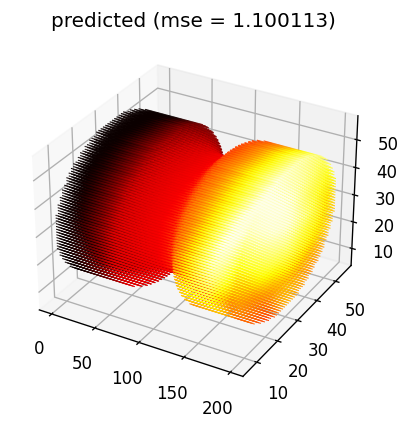

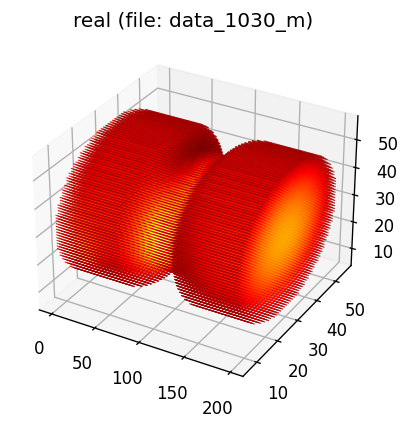

data_1030_m: 1.100113


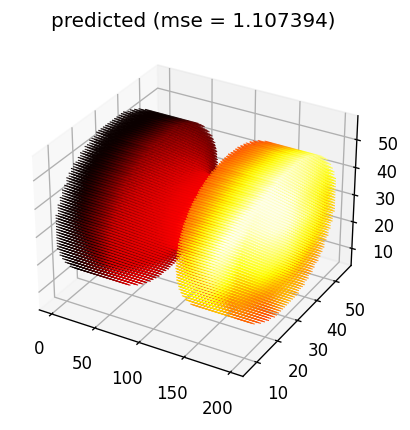

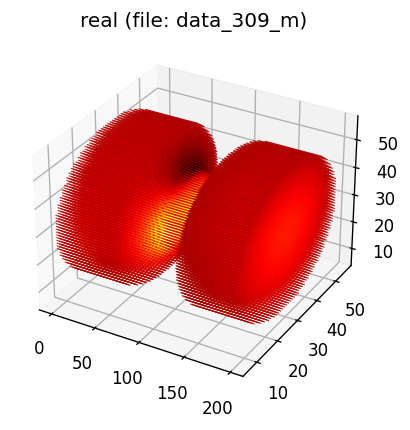

data_309_m: 1.107394


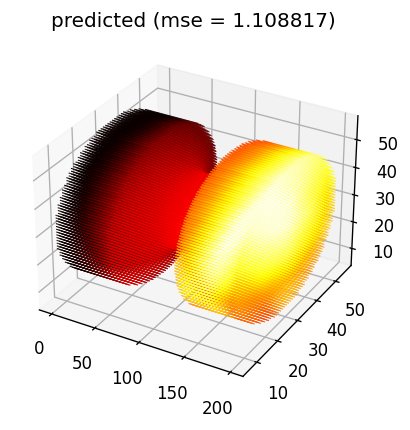

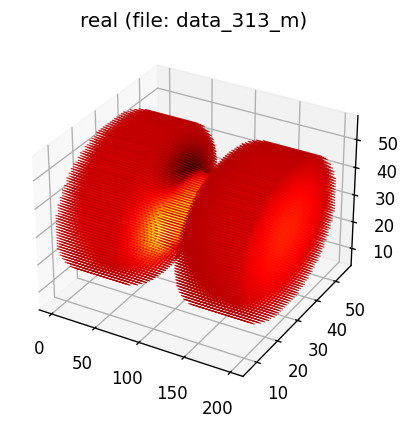

data_313_m: 1.108817


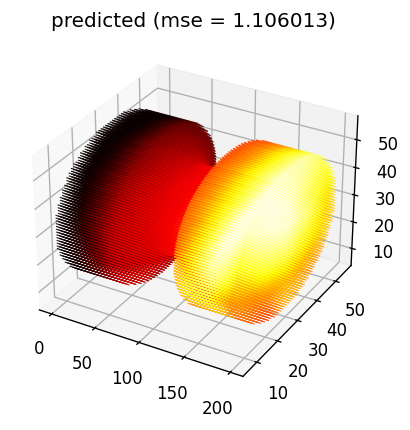

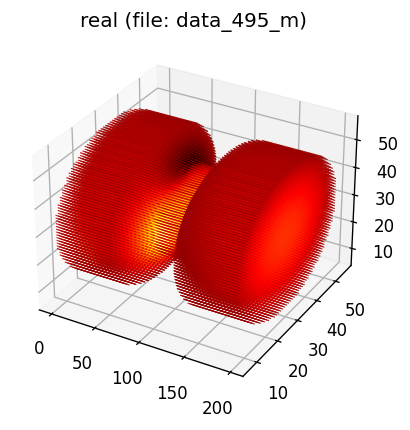

data_495_m: 1.106013


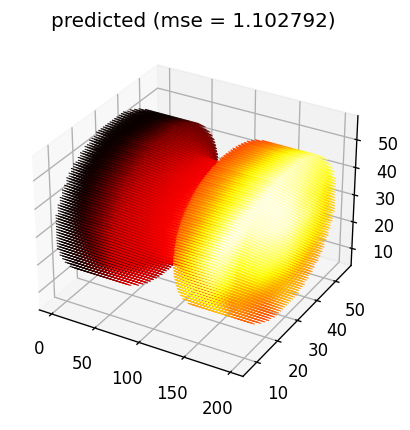

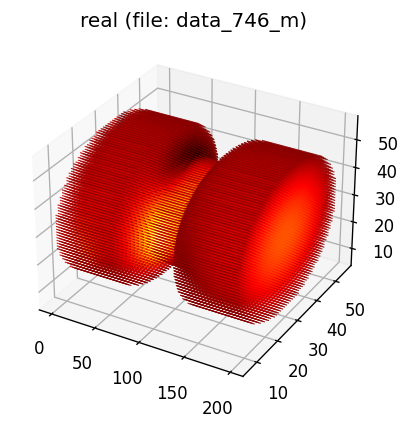

data_746_m: 1.102792


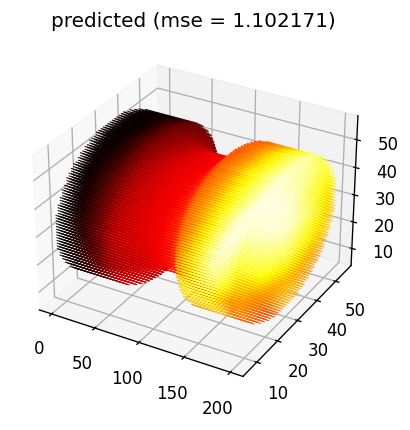

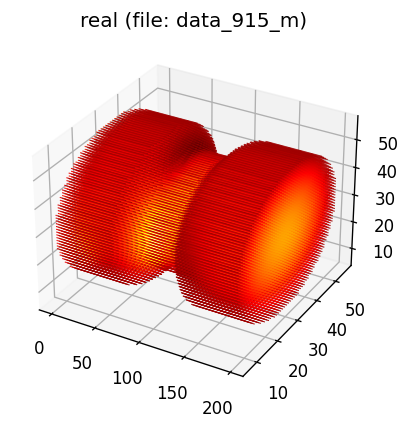

data_915_m: 1.102171


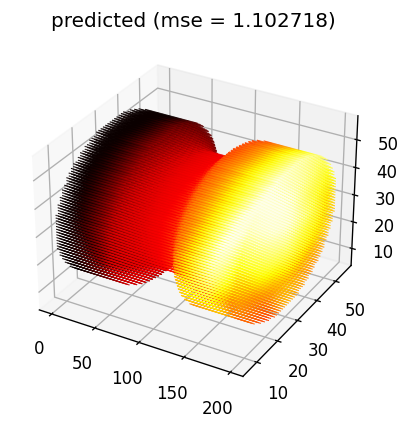

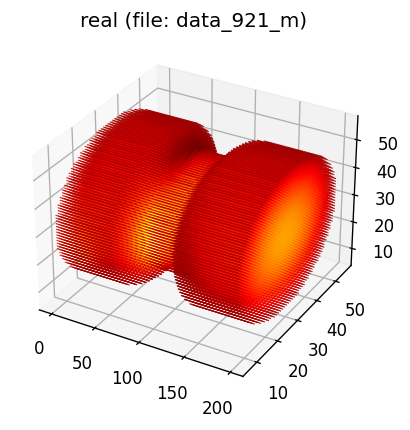

data_921_m: 1.102718


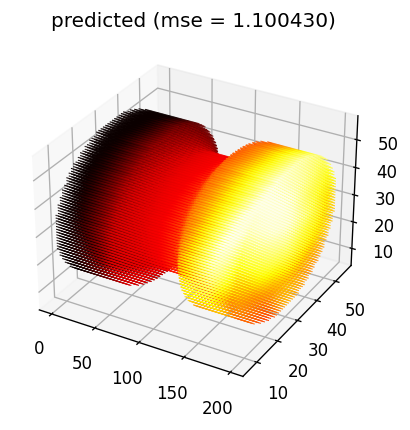

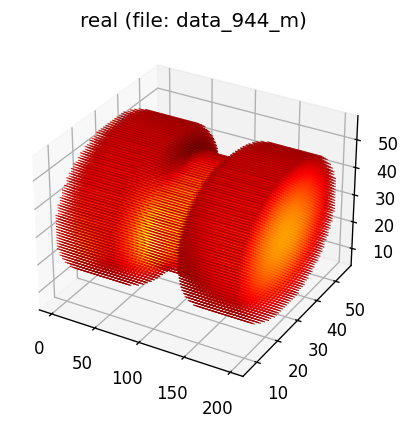

data_944_m: 1.100430


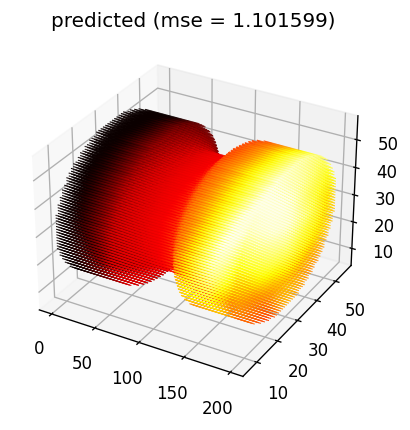

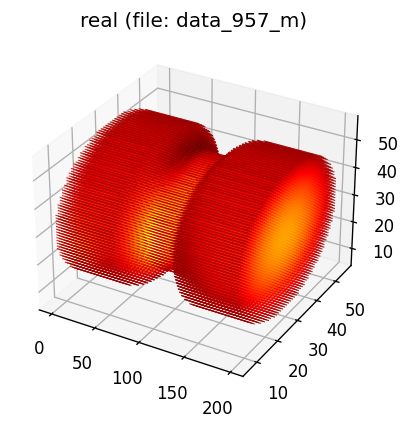

data_957_m: 1.101599


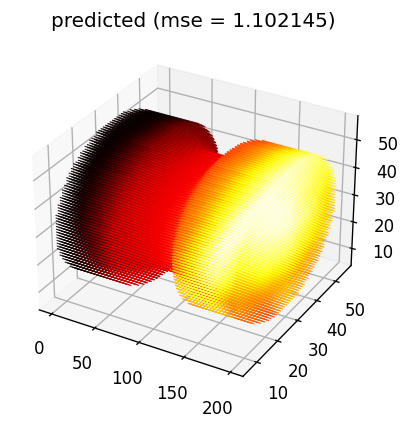

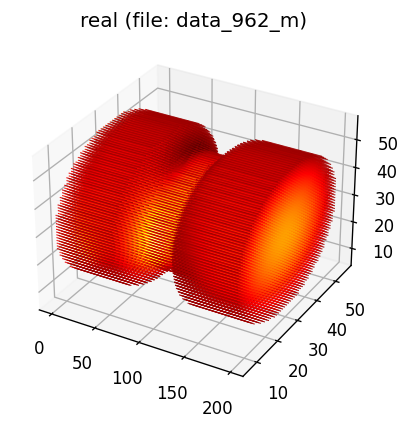

data_962_m: 1.102145


In [8]:
model = PointNet()
data = pickle.load(open('%s/%s_test_data.pkl'%(pkl_path, id_),'rb'))



#case_ = 0 # case number
#for case_ in range(len(data)):
for case_, _ in enumerate(data):
    fn = data[case_][0]
    mv = data[case_][1]
    pv = data[case_][2]
    y = data[case_][3]
    model([mv,pv[:1000,:]])
    model.load_weights('%s/%s_iter_model.h5'%(h5_path, id_))
    with tf.device('/CPU:0'): # GPU로 바꾸기
        pred = model([mv,pv],training=False)
        
    '''
    output_path_test = "D:/Junhong/DL/PointNet/3D Cardiovascular systerm flow prediction/result/%s_test"%(id_)
    if(not os.path.isdir(output_path_test)):
        os.mkdir(output_path_test)
        print("New folder is created")
    '''

    result = pd.DataFrame(np.concatenate([pv,pred],axis=-1))
    result.to_csv('%s/%s_pred_%s'%(output_path_test, id_, fn),header=False, index=False)
    
    gt_shape = pd.DataFrame(np.concatenate([pv,y],axis=-1))
    gt_shape.to_csv('%s/%s_gt_%s'%(output_path_test, id_, fn),header=False, index=False)


    mae = np.mean(np.abs(y-pred))
    mse = mae**2
    plt.close('all')
    cc1 = np.mean(np.abs(pred),axis=1)
    cc2 = np.mean(np.abs(y),axis=1)
    cc1 = (cc1-np.min(cc1))/(np.max(cc1)-np.min(cc1))
    cc2 = (cc2-np.min(cc2))/(np.max(cc2)-np.min(cc2))
    draw_pc(pv,cc1,'predicted (mse = %f)'%mse)
    draw_pc(pv,cc2,'real (file: %s)'%fn[:-4])
    plt.show()
    
    print('%s: %f'%(fn[:-4], mse))
    f0 = open("%s/id%s_mse_%s.txt"%(output_path_test, id_, fn[:-4]),'w')
    f0.write("mse:\n%f"%(mse))
    f0.close()